In diesem Jupyternotebook wird es um einen Vergleich zwischen der Arealstatistik und dem WorldCover 2020 Datensatz gehen.

In [1]:
# Change to your environment variables for PROJ and GDAL to ensure proper functioning of geospatial libraries.
import os
os.environ["PROJ_LIB"] = r"C:\Users\alexa\anaconda3\envs\WC\Library\share\proj"
os.environ["GDAL_DATA"] = r"C:\Users\alexa\anaconda3\envs\WC\Library\share\gdal"

# installieren von openpyxl, matplotlib, seaborn, scikit-learn falls noch nicht vorhanden
# pip install openpyxl
# pip install matplotlib
# pip install seaborn
# pip install scikit-learn


Noch mit der Arealstatistik von Zug

In [2]:
import geopandas as gpd
from shapely.geometry import box

# Punktlayer laden
punkte_gdf = gpd.read_file("../../../data/analysis/arealstatistik/ag-b-00.03-37-area-all-gpkg_zug.gpkg")

# # Prüfen, ob das Koordinatensystem Meter verwendet (EPSG:2056 für Schweiz)
# if punkte_gdf.crs.to_epsg() != 2056:
#     punkte_gdf = punkte_gdf.to_crs(epsg=2056)

def erstelle_quadrat(punkt, groesse=100):
    """
    Erstellt ein Quadrat ('Polygon') der angegebenen Größe (in Meter)
    um den Mittelpunkt eines Punktes.
    """
    x, y = punkt.x, punkt.y
    halb = groesse / 2
    return box(x - halb, y - halb, x + halb, y + halb)

# Quadrat-Geometrien für jeden Punkt erzeugen (100x100 m um Mittelpunkt)
punkte_gdf["geometry"] = punkte_gdf.geometry.apply(lambda p: erstelle_quadrat(p, groesse=100))

# Optional: als neuen Polygon-Layer speichern
punkte_gdf.to_file("../../../data/analysis/arealstatistik/arealstatistik_grid_zug_100m.gpkg", driver="GPKG")


c:\Users\jonas\anaconda3\envs\worldcover\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


Raster auf die gleiche Auflösung bringen (erstmals nur für Zug)

In [3]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Paths
raster_path = "../../../data/preprocessing/worldcover/2020/worldcover_2020_clipped.tif"
mask_path = "../../../data/analysis/arealstatistik/arealstatistik_grid_zug_100m.gpkg"

# Read buffered border
mask_gdf = gpd.read_file(mask_path)
print(mask_gdf.crs)

EPSG:2056


In [4]:
mask_geom = [mask_gdf.union_all()]  # Combine if multiple polygons

In [5]:
with rasterio.open(raster_path) as src:
    clipped_array, clipped_transform = mask(
        dataset=src,
        shapes=mask_geom,
        crop=True,
        nodata=0
    )
    clipped_meta = src.meta.copy()

clipped_meta.update({
    "driver": "GTiff",
    "height": clipped_array.shape[1],
    "width": clipped_array.shape[2],
    "transform": clipped_transform,
})

Raster speichern

In [9]:
out_path = "../../../data/analysis/worldcover/worldcover_2020_clipped_zug.tif"
with rasterio.open(out_path, "w", **clipped_meta) as dest:
    dest.write(clipped_array)

Raster werte den Polygonen zuordnen (häufigste Klasse pro Polygon)

In [10]:
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import pandas as pd

# Polygonlayer laden
polygons = gpd.read_file("../../../data/analysis/arealstatistik/arealstatistik_grid_zug_100m.gpkg")

# Pfad zum Raster
worldcover_raster = "../../../data/analysis/worldcover/worldcover_2020_clipped_zug.tif"

# Zonal stats für Kategorien zählen (alle Rasterzellen zählen)
stats = zonal_stats(
    polygons,
    worldcover_raster,
    categorical=True,
    all_touched=True,
    nodata=0,
    geojson_out=False
)

# Für alle Polygone
klass_1 = []
klass_1_p = []
klass_2 = []
klass_2_p = []
klass_3 = []
klass_3_p = []

for stat in stats:
    # Anzahl Zellen pro Klasse, sortieren absteigend
    if not stat:
        # Falls kein Wert (leeres Polygon)
        klass_1.append(-1)
        klass_1_p.append(0)
        klass_2.append(-1)
        klass_2_p.append(0)
        klass_3.append(-1)
        klass_3_p.append(0)
        continue

    gesamt = sum(stat.values())
    sorted_klassen = sorted(stat.items(), key=lambda x: x[1], reverse=True)

    # Top 1
    klass_1.append(sorted_klassen[0][0])
    klass_1_p.append(sorted_klassen[0][1] / gesamt * 100)

    # Top 2 (falls vorhanden)
    if len(sorted_klassen) > 1:
        klass_2.append(sorted_klassen[1][0])
        klass_2_p.append(sorted_klassen[1][1] / gesamt * 100)
    else:
        klass_2.append(-1)
        klass_2_p.append(0)

    # Top 3 (falls vorhanden)
    if len(sorted_klassen) > 2:
        klass_3.append(sorted_klassen[2][0])
        klass_3_p.append(sorted_klassen[2][1] / gesamt * 100)
    else:
        klass_3.append(-1)
        klass_3_p.append(0)

# Neue Spalten hinzufügen
polygons["WorldCover_2020_class_1"] = klass_1
polygons["WorldCover_2020_class_1_Percent"] = klass_1_p
polygons["WorldCover_2020_class_2"] = klass_2
polygons["WorldCover_2020_class_2_Percent"] = klass_2_p
polygons["WorldCover_2020_class_3"] = klass_3
polygons["WorldCover_2020_class_3_Percent"] = klass_3_p

# Ergebnis speichern
polygons.to_file("../../../data/analysis/worldcover/arealstatistik_grid_zug_100m_with_wc_top3.gpkg", driver="GPKG")


Arealstatistik Klassen den WorldCover Klassen zuordnen

In [11]:
import geopandas as gpd
import pandas as pd

# Arealstatistik-Daten laden
polygons = gpd.read_file("../../../data/analysis/worldcover/arealstatistik_grid_zug_100m_with_wc_top3.gpkg")

# Excel-Mappingtabelle laden
mapping_df = pd.read_excel("../../../data/analysis/worldcover/Mapping_AS_WC.xlsx")

# Angenommen, die Excel-Datei hat zwei Spalten: "AS18_72" und "WorldCover_class"
# Erstelle ein Mapping-Dictionary
mapping_dict = dict(zip(mapping_df["AS18_72"], mapping_df["WorldCover_class"]))

# Neue Spalte mit WorldCover Klassen erstellen basierend auf der Zuordnung
polygons["AS_auf_WorldCover"] = polygons["AS18_72"].map(mapping_dict)

# Fehlende Werte mit -1 ersetzen, ohne inplace=True
polygons["AS_auf_WorldCover"] = polygons["AS_auf_WorldCover"].fillna(-1)


# Ergebnis speichern
polygons.to_file("../../../data/analysis/worldcover/arealstatistik_zug_mapped.gpkg", driver="GPKG")


Confusion Matrix erstellen und auswerten

<Figure size 800x600 with 0 Axes>

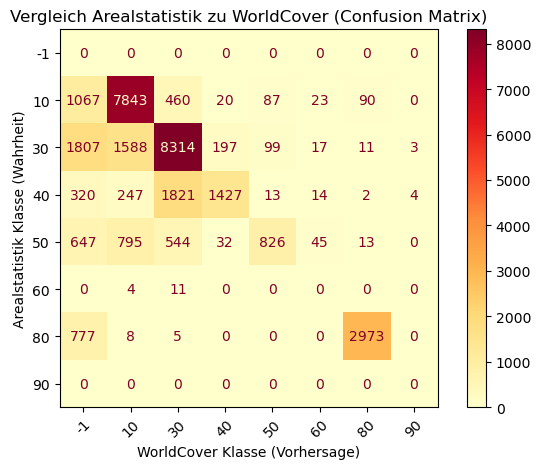

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# GeoDataFrame laden
df = gpd.read_file("../../../data/analysis/worldcover/arealstatistik_zug_mapped.gpkg")

# Klassen vergleichen
y_true = df["AS_auf_WorldCover"]
y_pred = df["WorldCover_2020_class_1"]

# Alle Klassen bestimmen
labels = sorted(set(y_true).union(set(y_pred)))

# Confusion Matrix erstellen
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Deutsche Achsen und Matrix anzeigen
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="YlOrRd", xticks_rotation=45)
plt.title("Vergleich Arealstatistik zu WorldCover (Confusion Matrix)")
plt.xlabel("WorldCover Klasse (Vorhersage)")
plt.ylabel("Arealstatistik Klasse (Wahrheit)")
plt.tight_layout()
plt.show()


Confusion Matrix erstellen zum verifizieren der Klassenzuordnung

In [13]:
import geopandas as gpd
import pandas as pd

# GeoDataFrame laden
df = gpd.read_file("../../../data/analysis/worldcover/arealstatistik_zug_mapped.gpkg")

# Kreuztabelle erstellen:
crosstab = pd.crosstab(
    df["AS18_72"],                      # Zeilen: originale AS Klassen
    df["WorldCover_2020_class_1"],      # Spalten: WorldCover Klassen
    rownames=["AS18_72"],               # Deutsche Achsen-Beschriftungen
    colnames=["WorldCover_2020_class_1"]
)

# Tabelle zeigen/prüfen
print(crosstab)

# Optional: Als Excel oder CSV abspeichern
crosstab.to_csv("../../../data/analysis/worldcover/AS_WC_kreuztabelle_zug.csv")
crosstab.to_excel("../../../data/analysis/worldcover/AS_WC_kreuztabelle_zug.xlsx")


WorldCover_2020_class_1  -1    10   30   40   50   60   80   90
AS18_72                                                        
1                         21    5    2    1  119    1    0    0
2                         39   14    9    1  150    3    0    0
3                         41   62   19    0   19    1    1    0
4                        116  208  103    3   41    1    3    0
5                          8   21    4    0    7    0    0    0
...                      ...  ...  ...  ...  ...  ...  ...  ...
67                        47  133  588    1    0    0   10    3
68                         0    1    0    0    0    0    0    0
69                         0    2    8    0    0    0    0    0
70                         0    2    3    0    0    0    0    0
71                         1    1    5    1    0    0    0    0

[67 rows x 8 columns]
